# Image inpainting over CIFAR-10

The purpose of this project is to build and train a neural network for image inpainting over the CIFAR-10 dataset. 

Inpainting is a restauration process where damaged, deteriorated, or missing parts of an artwork are filled in to present a complete image.

In our case, we create the portion of the image to be filled in by cropping a fixed size rectangular area from CIFAR-10 images.

The networks must be trained over the training set, and tested on the test set.
You can split the train set into a validation set, if you wish.

The metrics that will be used to evaluate you result is Mean Square Error.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras import metrics
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Concatenate, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import cifar10

Here we load the dataset.

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape)
print(x_test.shape)
print("image range is {}, {}".format(np.min(x_test,axis=(0,1,2,3)),np.max(x_test,axis=(0,1,2,3))))
x_train = (x_train/255.).astype(np.float32)
x_test = (x_test/255.).astype(np.float32)
print("new image range is {}, {}".format(np.min(x_test,axis=(0,1,2,3)),np.max(x_test,axis=(0,1,2,3))))

170498071/170498071 [==============================] - 6s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)
image range is 0, 255
new image range is 0.0, 1.0


Let's see some examples.

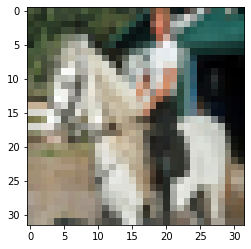

In [4]:
plt.imshow(x_test[56])
plt.show()

Now we hide a portion of the input, and the purpose of the network is to reconstruct it.

In [5]:
def mask(X,coords):
  x0,y0,x1,y1 = coords
  X[:,x0:x1,y0:y1] = 1
  return X

masked_x_train = mask(np.copy(x_train),(2,16,30,30))
masked_x_test = mask(np.copy(x_test),(2,16,30,30))

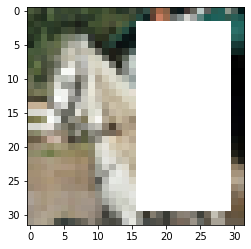

In [6]:
plt.imshow(masked_x_test[56])
plt.show()

# Approaches and evaluation

The network is supposed to take in input the masked image and fill in the missing part. 

You may basically follow two main approaches:
*   either you return the full image
*   you just return the missing crop

In the first case, the mse is to be evaluated on the full image; in the second case just on the crop (since on the reamining part is 0). 

If you want to take a different approach, you can ask for my approuval.



# What to deliver

As usual, you are supposed to deliver a single notebook comprising the code, the training history, and the evaluation on test data in terms of Mean Square Error.

Good work!

# Implementation


The approach I choose for this task is to build an Autoencoder, which takes in input masked images and outputs a reconstruction of them. The Autoencoder is built as a CNN that has a U-net shape. After several attempts, this looks like the network whose reconstructed images, obtained from the CIFRAR-10 dataset, are the most accurate.

## Neural Network

### Definition

In [10]:
def ConvBlock(filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
    conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    if pool_layer:
      pool = MaxPooling2D(pool_size)(conv)
      return conv, pool
    else:
      return conv


def UpConvBlock(filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
    conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    up = Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
    up = Concatenate(axis=3)([up, shared_layer])

    return conv, up


def build(input_size=(32,32,3)):
    inputs = Input(input_size)

    conv1, pool1 = ConvBlock(32, (3,3), (2,2), 'relu', 'same', inputs) 
    conv2, pool2 = ConvBlock(64, (3,3), (2,2), 'relu', 'same', pool1)
    conv3, pool3 = ConvBlock(128, (3,3), (2,2), 'relu', 'same', pool2) 
    conv4, pool4 = ConvBlock(256, (3,3), (2,2), 'relu', 'same', pool3) 
    
    conv5, up6 = UpConvBlock(512, 256, (3,3), (2,2), (2,2), 'relu', 'same', pool4, conv4)
    conv6, up7 = UpConvBlock(256, 128, (3,3), (2,2), (2,2), 'relu', 'same', up6, conv3)
    conv7, up8 = UpConvBlock(128, 64, (3,3), (2,2), (2,2), 'relu', 'same', up7, conv2)
    conv8, up9 = UpConvBlock(64, 32, (3,3), (2,2), (2,2), 'relu', 'same', up8, conv1)
    
    conv9 = ConvBlock(32, (3,3), (2,2), 'relu', 'same', up9, False)
    
    outputs = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv9)

    return Model(inputs=[inputs], outputs=[outputs])  

### Summary

In [11]:
K.clear_session()
model = build()
model.summary()
model.compile(optimizer='adam', loss='mean_absolute_error')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 32)   9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 16, 32)   0           ['conv2d_1[0][0]']               
                                                                                              

## Training

In [12]:
P = model.fit(masked_x_train, x_train, 
          validation_data=(masked_x_test,x_test), 
          epochs=20, 
          use_multiprocessing=True)

Epoch 1/20
1563/1563 [==============================] - 49s 25ms/step - loss: 0.0632 - val_loss: 0.0499
Epoch 2/20
1563/1563 [==============================] - 35s 23ms/step - loss: 0.0495 - val_loss: 0.0466
Epoch 3/20
1563/1563 [==============================] - 39s 25ms/step - loss: 0.0467 - val_loss: 0.0468
Epoch 4/20
1563/1563 [==============================] - 35s 23ms/step - loss: 0.0454 - val_loss: 0.0443
Epoch 5/20
1563/1563 [==============================] - 34s 22ms/step - loss: 0.0445 - val_loss: 0.0441
Epoch 6/20
1563/1563 [==============================] - 36s 23ms/step - loss: 0.0436 - val_loss: 0.0458
Epoch 7/20
1563/1563 [==============================] - 34s 22ms/step - loss: 0.0429 - val_loss: 0.0504
Epoch 8/20
1563/1563 [==============================] - 34s 22ms/step - loss: 0.0422 - val_loss: 0.0420
Epoch 9/20
1563/1563 [==============================] - 35s 23ms/step - loss: 0.0418 - val_loss: 0.0420
Epoch 10/20
1563/1563 [==============================] - 34s 22m

The following chart will show how the loss function reduces during the training process.

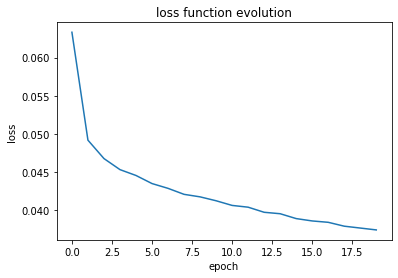

In [ ]:
plt.plot(history.history['loss'])
plt.title('loss function evolution')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

## Evaluation

Let's first obtain the reconstructed images for the testing set.

In [13]:
decoded_imgs = model.predict(masked_x_test)

313/313 [==============================] - 3s 7ms/step


Then plot them togheter with the original one.

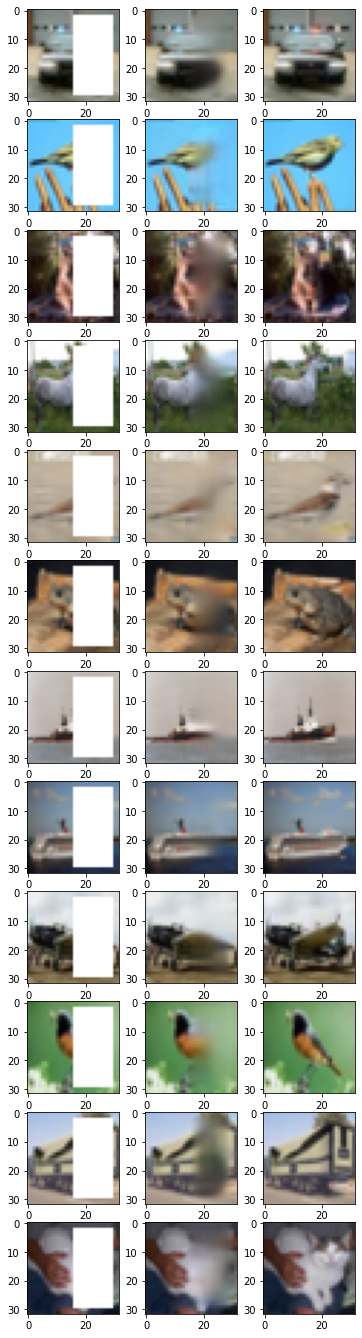

In [19]:
samples = 12
shift = 66

fig, axs = plt.subplots(nrows=samples, ncols=3, figsize=(6,2*samples))

for i in range(samples):
  axs[i][0].imshow(masked_x_test[i+shift])
  axs[i][1].imshow(decoded_imgs[i+shift])
  axs[i][2].imshow(x_test[i+shift])

plt.show()

The Mean Square Error between original images and images obtained with the model is around 0.0087.

In [15]:
mse = np.mean(np.square(decoded_imgs - x_test))
print(mse)

0.008768241
